# CSCI-UA 0473 - Introduction to Machine Learning
## Wednesday, April 4, 2017

This lab will go through a real-world (?) linear regression example, showing how to
* Load data from Excel using `pandas`.
* Efficiently preprocess tabular data using `pandas`.
* Do Linear/Ridge (i.e. with L2 regularization)/Lasso (i.e. with L1 regularization) regression using `autograd` and `scikit-learn`.

To get an intuition on how linear regression works on 1D examples, see https://github.com/nyu-dl/Intro_to_ML_Lecture_Note/blob/master/notebook/Linear%20Regression%201.ipynb.

In [1]:
import pandas as pd
import autograd.numpy as np
from autograd import grad
import scipy.optimize
from sklearn.linear_model import LinearRegression, Ridge, Lasso

### Loading data

The data file is `AmesHousing.xls`, which [asks you to predict the final price of each housing given 79 features, some of them numeric and others categorical](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

Now let's load it into something playable in Python:

In [2]:
data = pd.read_excel('AmesHousingFiltered.xls')
n_examples = data.shape[0]
n_train = 1000
data

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,105000
1,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,172000
2,7,527127150,120,RL,41.0,4920,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,213500
3,8,527145080,120,RL,43.0,5005,Pave,NaN,IR1,HLS,...,144,0,NaN,NaN,NaN,0,1,2010,WD,191500
4,12,527165230,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,...,0,0,NaN,GdPrv,Shed,500,3,2010,WD,185000
5,13,527166040,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,5,2010,WD,180400
6,14,527180040,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,2,2010,WD,171500
7,19,527276150,20,RL,140.0,19138,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,6,2010,WD,141000
8,24,527402200,20,RL,NaN,11241,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,Shed,700,3,2010,WD,149000
9,25,527402250,20,RL,NaN,12537,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,149900


Apparently we cannot directly feed this table into `scikit-learn` or most machine learning system, since
* Some of the columns contain strings.
* Some entries are missing. (e.g. `Lot Frontage`)
* Some columns seem irrelevant to house price prediction, e.g. `Order` and `PID` look like some identification of each transaction, and therefore should *never* be used as a part of the input (QUESTION: WHY NOT?).

To have a big picture of what each column does, we need to look at its documentation (or, in companies, ask the people who generated such data).  As machine learning engineers, maybe we don't need to figure out the precise business meaning of each column, but we do need to know whether a number in a column *is* a number.

The documentation for this data is in `DataDocumentation.txt`.  After reading the documentation, we can see that:
* `Order` and `PID` are indeed identifications and therefore we want to remove them.
* `MS Subclass` is a *categorical* variable instead of a number (that is, different values are treated equally), so the numbers inside are very deceiving.
* A lot of columns with strings are actually *ordinal*, which means that the values have an ordering.  Namely, `Lot Shape`, `Utilities`, `Land Slope`, `Exter Qual`, `Exter Cond`, `Bsmt Qual`, `Bsmt Cond`, `Bsmt Exposure`, `BsmtFin Type 1`, `BsmtFin Type 2`, `HeatingQC`, `Electrical`, `KitchenQual`, `FireplaceQu`, `Garage Finish`, `Garage Qual`, `Garage Cond`, `Paved Drive`, `Pool QC`, `Fence` are ordinal.

The next thing we need to do is to *preprocess the table*, that is, to transform the columns in the table into statistical variables.  Luckily, `pandas` is powerful enough (one can think of it as a programmatic Excel), so most of the work can be done there.

### Preprocessing
Let's first start with removing the `Order` and `PID` columns.

In [3]:
data.drop(['Order', 'PID'], axis=1, inplace=True) # axis=1 means to drop columns, while inplace=True
                                                  # tells it to modify the table in-place.
data

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,105000
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,172000
2,120,RL,41.0,4920,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2010,WD,213500
3,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,191500
4,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,GdPrv,Shed,500,3,2010,WD,185000
5,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2010,WD,180400
6,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2010,WD,171500
7,20,RL,140.0,19138,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,6,2010,WD,141000
8,20,RL,NaN,11241,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,Shed,700,3,2010,WD,149000
9,20,RL,NaN,12537,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,4,2010,WD,149900


Next, we need to turn the `MS Subclass` column into categorical column.

The type of each column can be shown by checking `data.dtypes`, and changed by `data.astype()`.  When the `dtype` of a column is `object`, it means that the column is categorical.

In [4]:
data.dtypes

MS SubClass         int64
MS Zoning          object
Lot Frontage      float64
Lot Area            int64
Street             object
Alley              object
Lot Shape          object
Land Contour       object
Utilities          object
Lot Config         object
Land Slope         object
Neighborhood       object
Condition 1        object
Condition 2        object
Bldg Type          object
House Style        object
Overall Qual        int64
Overall Cond        int64
Year Built          int64
Year Remod/Add      int64
Roof Style         object
Roof Matl          object
Exterior 1st       object
Exterior 2nd       object
Mas Vnr Type       object
Mas Vnr Area      float64
Exter Qual         object
Exter Cond         object
Foundation         object
Bsmt Qual          object
                   ...   
Half Bath           int64
Bedroom AbvGr       int64
Kitchen AbvGr       int64
Kitchen Qual       object
TotRms AbvGrd       int64
Functional         object
Fireplaces          int64
Fireplace Qu

In [5]:
data = data.astype({'MS SubClass': object}) # astype() does not support in-place operation
data.dtypes

numeric_columns = data.columns[data.dtypes != np.object]

The next thing we need to deal with is categorical variables, including ordinal variables.

The laziest way to deal with ordinal variables is to treat them as if they don't have an ordering.  Of course, there are other ways to deal with that (e.g. assigning an integer).

After that, we must deal with categorical variables.  The most straightforward way is that, for a categorical variable with N classes, we create N binary variables, each for a specific class, then set the variable corresponding to the actual class to 1, and all others to 0.  The variables are sometimes called "dummy variables", or "one-hot encoding", etc.

Missing categorical values (shown as `NaN` or `None` in `pandas` table) should be treated separately with caution.  In our case, the documentation made it clear that "NA" categorical values simply denotes that the corresponding attribute does not apply to this housing (e.g. when the value in the column `Alley` is `NaN`, it means that there is no alley access), so we can handle these values by setting all the binary variables to 0.

Fortunately, `pandas` can convert the categorical values into binary variables with a single call.

In [6]:
data = pd.get_dummies(data)
data

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Misc Feature_Shed,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_Oth,Sale Type_VWD,Sale Type_WD
0,80.0,11622,5,6,1961,1961,0.0,468,144,270,...,0,0,0,0,0,0,0,0,0,1
1,81.0,14267,6,6,1958,1958,108.0,923,0,406,...,0,0,0,0,0,0,0,0,0,1
2,41.0,4920,8,5,2001,2001,0.0,616,0,722,...,0,0,0,0,0,0,0,0,0,1
3,43.0,5005,8,5,1992,1992,0.0,263,0,1017,...,0,0,0,0,0,0,0,0,0,1
4,NaN,7980,6,7,1992,2007,0.0,935,0,233,...,1,0,0,0,0,0,0,0,0,1
5,63.0,8402,6,5,1998,1998,0.0,0,0,789,...,0,0,0,0,0,0,0,0,0,1
6,85.0,10176,7,5,1990,1990,0.0,637,0,663,...,0,0,0,0,0,0,0,0,0,1
7,140.0,19138,4,5,1951,1951,0.0,120,0,744,...,0,0,0,0,0,0,0,0,0,1
8,NaN,11241,6,7,1970,1970,180.0,578,0,426,...,1,0,0,0,0,0,0,0,0,1
9,NaN,12537,5,6,1971,2008,0.0,734,0,344,...,0,0,0,0,0,0,0,0,0,1


We can see that there are still some missing values here and there.

Arguably the easiest way to handle missing values is to delete them.  So let's see whether we can do that with little impact, by checking how many missing values are there for each column.

In [7]:
null_count = data.isnull().sum(axis=0)
null_count[null_count > 0]

Lot Frontage     234
Mas Vnr Area       5
Garage Yr Blt     89
dtype: int64

We can see that there are still three columns with missing values, which we need to *impute* using either domain knowledge, averaging the known values, or treating them as unobserved variable (which is beyond the scope of the course).

From the documentation we know that `Mas Vnr Area` is missing only if `Mas Vnr Type` is `None`, that is, there is no Masonry Vaneer).  So we can safely fill the missing values there by 0.

The `Garage Yr Blt` field also has many missing values.  However, the table has a column called `Year Remod/Add`, which contains the year of remodeling.  Maybe we can assume that the year of building the garage to be the same as the year of refitting the house.

`Lot Frontage` has a particularly large number of missing values.  Here, we fill the values using the average `Lot Frontage` values.  A caveat is that the aggregated statistics such as average should be *only* computed on the training set, to prevent the leakage of test set information into the preprocessing (hence training) procedure.

In [8]:
data = data.fillna(
    {'Mas Vnr Area': 0,
     'Garage Yr Blt': data['Year Remod/Add'],
     'Lot Frontage': data.loc[:n_train, 'Lot Frontage'].mean() # the aggregation method in pandas usually excludes NaNs by default
    })
data

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Misc Feature_Shed,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_Oth,Sale Type_VWD,Sale Type_WD
0,80.000000,11622,5,6,1961,1961,0.0,468,144,270,...,0,0,0,0,0,0,0,0,0,1
1,81.000000,14267,6,6,1958,1958,108.0,923,0,406,...,0,0,0,0,0,0,0,0,0,1
2,41.000000,4920,8,5,2001,2001,0.0,616,0,722,...,0,0,0,0,0,0,0,0,0,1
3,43.000000,5005,8,5,1992,1992,0.0,263,0,1017,...,0,0,0,0,0,0,0,0,0,1
4,63.231515,7980,6,7,1992,2007,0.0,935,0,233,...,1,0,0,0,0,0,0,0,0,1
5,63.000000,8402,6,5,1998,1998,0.0,0,0,789,...,0,0,0,0,0,0,0,0,0,1
6,85.000000,10176,7,5,1990,1990,0.0,637,0,663,...,0,0,0,0,0,0,0,0,0,1
7,140.000000,19138,4,5,1951,1951,0.0,120,0,744,...,0,0,0,0,0,0,0,0,0,1
8,63.231515,11241,6,7,1970,1970,180.0,578,0,426,...,1,0,0,0,0,0,0,0,0,1
9,63.231515,12537,5,6,1971,2008,0.0,734,0,344,...,0,0,0,0,0,0,0,0,0,1


Finally, we normalize the numeric features by subtracting the mean and dividing by the standard deviation of each feature, so that the numbers are centered at 0 and have roughly the same scale.  While you don't need normalization for linear regression without any regularization, including it makes more sense for ridge regression since the regularization term depends on the scale of the weights, which in turn depend on the scale of the features.

In [9]:
mean = data.loc[:n_train, numeric_columns].mean()
std = data.loc[:n_train, numeric_columns].std()
data[numeric_columns] = (data[numeric_columns] - mean) / std

mean_saleprice = mean['SalePrice']
std_saleprice = std['SalePrice']

Now the data is ready for machine learning systems.

### Linear Regressions Using `autograd`

Although the optimal linear regression and ridge regression solution can be found analytically (the solution for linear regression is unfortunately a homework assignment), here we will show how to do linear regression with in `autograd` instead, since we don't have to restrict ourselves in linear models.  By using auto-differentiation, we can easily replace the linear model with adaptive basis function networks or even neural networks (both beyond the scope of the course) using the very same cost function, to model the data more accurately.

In [10]:
def preprocess(data, n_train):
    # as_matrix() turns pandas tables and columns into numpy arrays.
    # Recall that np actually comes from autograd.  So np.array() wraps the vanilla numpy array into an autograd numpy array.
    labels = np.array(data['SalePrice'].as_matrix())
    data_matrix = np.array(data.drop('SalePrice', axis=1).as_matrix())
    columns = data.drop('SalePrice', axis=1).columns.tolist()

    # Pick the first 1000 examples as training data.
    train_data = data_matrix[:n_train]
    train_labels = labels[:n_train]
    test_data = data_matrix[n_train:]
    test_labels = labels[n_train:]

    n_features = train_data.shape[1]
    print('Number of features:', n_features)
    
    return train_data, train_labels, test_data, test_labels, columns, n_features

train_data, train_labels, test_data, test_labels, columns, n_features = preprocess(data, n_train)
actual_test_labels = test_labels * std_saleprice + mean_saleprice

Number of features: 286


In [11]:
def predict(params, X):
    w, b = params[:-1], params[-1]
    y_hat = np.dot(X, w) + b
    return y_hat

def cost(params, X, y, lambda_l2=0, lambda_l1=0):
    y_hat = predict(params, X)
    return ((y_hat - y) ** 2).mean() + lambda_l2 * (params ** 2).sum() + lambda_l1 * np.abs(params).sum()

cost_grad = grad(cost)

After we define the model, we train it by first initializing a set of weights, then minimizing the cost function, which is the mean squared error.

Note that the following code initializes parameters to be all zeros.  This is only for reproducibility.  In practice we often randomly initialize it.

In [12]:
params = np.zeros(n_features + 1)
model = scipy.optimize.minimize(cost, params, (train_data, train_labels), jac=cost_grad, options={'maxiter': 50000})
params = model.x

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
def print_distribution_summary(a):
    print('Average', a.mean())
    # Check the distribution by looking at minimum, maximum, and quartiles.
    print('Minimum', a.min())
    print('25% percentile', np.percentile(a, 25))
    print('Median', np.percentile(a, 50))
    print('75% percentile', np.percentile(a, 75))
    print('Maximum', a.max())
    
def plot_distribution_summaries(arrs, labels):
    plt.gcf().set_size_inches(12, 4)
    plt.boxplot(arrs, labels=labels, vert=False, showmeans=True)

Average -716.9115283866886
Minimum -74104.2915046227
25% percentile -7915.167078267616
Median -365.1049563642446
75% percentile 7552.73050616734
Maximum 43099.56789202892


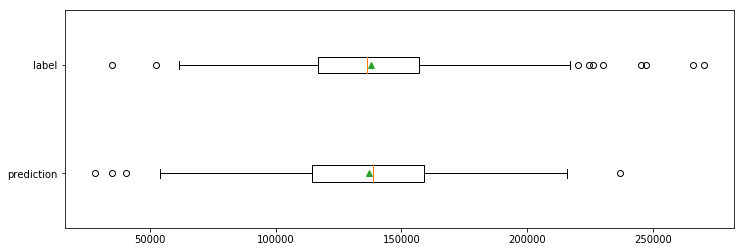

In [14]:
test_prediction = predict(params, test_data)
actual_prediction = test_prediction * std_saleprice + mean_saleprice # undo the normalization
# Check whether the model tends to underestimate or overestimate the housing price
error = actual_prediction - actual_test_labels
print_distribution_summary(error)
plot_distribution_summaries([actual_prediction, actual_test_labels], ['prediction', 'label'])

So we can see that the linear model slightly tends to underestimate the housing prices.

A nice thing about linear models is that the weight values directly show the impact of the corresponding variables, so we can easily understand what the model is doing by printing out the weights.

Unfortunately, we have around 300 features in the dataset, so instead we can check which variables would contribute the most to the housing prices, both positively and negatively, as well as which variables are the most irrelevant.

In [15]:
def print_most_significant_params(params, names, k):
    names = names + ['bias']
    param_sorted_index = np.argsort(params)
    # print the top-k most positive factors
    print('Most positive factors')
    for i in range(k):
        idx = param_sorted_index[-i - 1]
        print(names[idx], params[idx])
    # the top-5 most negative factors
    print('Most negative factors')
    for i in range(k):
        idx = param_sorted_index[i]
        print(names[idx], params[idx])

In [16]:
print_most_significant_params(params, columns, 10)

Most positive factors
MS Zoning_I (all) 1.2145693954469083
Neighborhood_Somerst 0.7657825568856429
Exterior 2nd_AsphShn 0.6103426596729834
Utilities_AllPub 0.5256932010296204
Condition 1_RRNn 0.5165488301476371
Condition 2_RRNn 0.5141347745237305
Neighborhood_Greens 0.47421085754157183
Exterior 1st_BrkFace 0.45430071686019274
Neighborhood_NridgHt 0.4001043306856618
Garage Qual_Gd 0.37972612573733533
Most negative factors
Functional_Maj2 -0.8569290782619009
Utilities_NoSewr -0.6551367086976253
MS Zoning_C (all) -0.5670088686881116
Exterior 2nd_Stone -0.5604075112792402
MS SubClass_190 -0.5596065270828504
Condition 2_Artery -0.5438604205437737
Exterior 2nd_ImStucc -0.5343280690143549
Condition 2_Feedr -0.4114618391377859
Neighborhood_Blmngtn -0.40703788835904137
Condition 1_RRAe -0.4055704839761634


With the model above, it is tempting to say that people likes the housing in industrial zone *a lot* (see documentation for the field `MS Zoning`).  Is this really the case?  Or maybe there is too few samples of such examples to be representative at all, so they should be considered as outliers instead?

In [17]:
print('Number of housings in industrial zone:', data[data['MS Zoning_I (all)'] == 1].shape[0])

Number of housings in industrial zone: 1


### Ridge Regression

From the example above, we can see that linear regression would try to adjust the weights of uncommon features to fit the output against the target as close as possible.  Usually, this will result in large weights on uncommon features, which leads to potentially misleading interpretations (e.g. "people *LOVE* living in industrial zones!!!!")

Ridge regression is essentially linear regression with L2 penalty on the weights.  By imposing such a penalty, we are essentially saying that the weight values should not be too large in general.

<div class="alert alert-info">
**Math**: In fact, imposing an L2 penalty (which is a soft constraint) is equivalent to saying that the L2 norm of the weight vector should never exceed some constant (which is a hard constraint).  The former is called *Tikhonov regularization* and the latter *Ivanov regularization*.
</div>

L2 penalty is also equivalent to assuming a Gaussian prior on the weight values, i.e. the belief that a weight vector with a large L2 norm is unlikely.  Now let's try ridge regression with an L2 penalty coefficient of 1.

Average 579.082286811342
Minimum -86704.18677322363
25% percentile -5930.4890505955045
Median 1551.4111453470105
75% percentile 9037.190734354619
Maximum 34267.13261502827
Most positive factors
Overall Qual 0.14082234756457504
Gr Liv Area 0.10601359804506343
Total Bsmt SF 0.09494335161207659
1st Flr SF 0.08544563485955609
Year Built 0.08188308175205972
BsmtFin SF 1 0.06932649590784128
Year Remod/Add 0.06867452934627245
Garage Cars 0.06808129618477153
Garage Area 0.062423720175855554
Fireplaces 0.05828695567875622
Most negative factors
Kitchen Qual_TA -0.03339185892070987
Heating QC_TA -0.030262477518356395
Exter Qual_TA -0.029911189495370995
Lot Shape_Reg -0.025632878482801724
MS Zoning_RM -0.025167347573956132
Garage Type_Detchd -0.022156598324183863
Central Air_N -0.02042615937671837
MS SubClass_30 -0.019103211234087945
Garage Finish_Unf -0.018618825466125602
Bsmt Exposure_No -0.0183057761981486


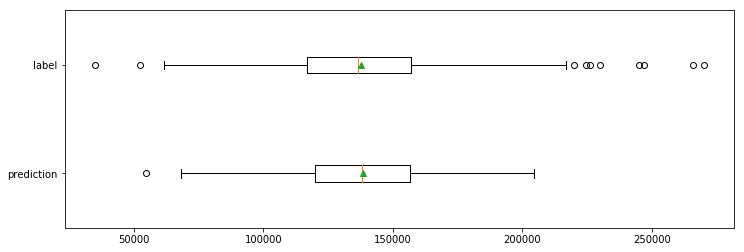

In [18]:
params = np.zeros(n_features + 1)
model = scipy.optimize.minimize(cost, params, (train_data, train_labels, 1), jac=cost_grad)
params = model.x
test_prediction = predict(params, test_data)
actual_prediction = test_prediction * std_saleprice + mean_saleprice # undo the normalization
# Check whether the model tends to underestimate or overestimate the housing price
error = actual_prediction - actual_test_labels
print_distribution_summary(error)
print_most_significant_params(params, columns, 10)
plot_distribution_summaries([actual_prediction, actual_test_labels], ['prediction', 'label'])

The resulting model actually makes more (business) sense, as we can see that people value overall quality, living area, size of floors, and age (of course!), while they don't like 1-story super old buildings (see documentation of `MS SubClass` with value `030`).

### Lasso

Lasso, or linear regression with L1 penalty, is yet another common method for fitting continuous values.  It is particularly interesting because the resulting weight vector is usually *sparse*.

However, directly applying gradient descent on Lasso cost function does not necessarily give you a sparse solution, since it will usually have a hard time getting you to the actual zeros (think of the model swinging around the V-shape but having trouble getting to the actual bottom).

In [19]:
params = np.zeros(n_features + 1)
model = scipy.optimize.minimize(cost, params, (train_data, train_labels, 0, 0.1), jac=cost_grad)
params = model.x

print('Number of "should be" nonzeros', (np.abs(params) > 1e-4).sum()) # the number of weight components that "should be likely" nonzero
print('Number of nonzeros', (params != 0).sum()) # the number of actual nonzero weights

Number of "should be" nonzeros 17
Number of nonzeros 281


If we only adjust one weight component at a time, while fixing others, it is actually possible to find the exact solution for that component, which often gives you exact zeros.  Such algorithm is called *coordinate descent*, and is the algorithm used by `scikit-learn`.

If interested, one can see [this video lecture on Coursera](https://www.coursera.org/learn/ml-regression/lecture/uHBq7/coordinate-descent) explains the actual algorithm in detail.  Here we are only running `scikit-learn` to see how to use Lasso regression with `sklearn.linear_model.Lasso`.

`scikit-learn` also has its own implementation of linear regression and ridge regression, but we won't go through the detail here as the code is very similar to that of Lasso.

Average 205.56803775610027
Minimum -75877.6364150857
25% percentile -8022.242830543997
Median 1296.0505041636934
75% percentile 9848.185178770742
Maximum 48581.47389830687
Most positive factors
Overall Qual 0.28609961763134534
Year Built 0.1676976545355975
Gr Liv Area 0.16738324611534752
1st Flr SF 0.12528080493461724
Total Bsmt SF 0.10656650176043792
Year Remod/Add 0.09697876087462434
BsmtFin SF 1 0.07132877484575813
Garage Cars 0.06371772340571333
Garage Area 0.03777300920780822
Lot Area 0.014595164527473538
Most negative factors
Lot Frontage 0.0
Bsmt Cond_Fa -0.0
Bsmt Cond_Ex -0.0
Bsmt Qual_TA -0.0
Bsmt Qual_Po -0.0
Bsmt Qual_Gd 0.0
Bsmt Qual_Fa -0.0
Bsmt Cond_Gd 0.0
Bsmt Qual_Ex 0.0
Foundation_Stone -0.0
Number of nonzero coefficients 12


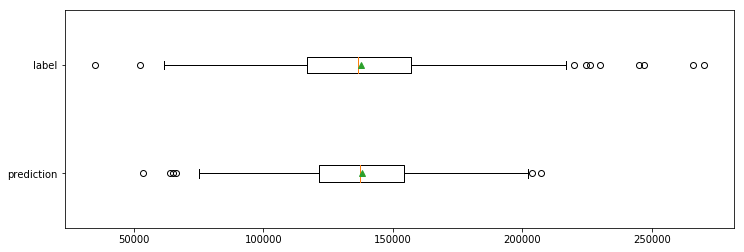

In [20]:
lr = Lasso(alpha=0.1, max_iter=10000)
lr.fit(train_data, train_labels)
test_prediction = lr.predict(test_data)
actual_prediction = test_prediction * std_saleprice + mean_saleprice # undo the normalization
# Check whether the model tends to underestimate or overestimate the housing price
error = actual_prediction - actual_test_labels
print_distribution_summary(error)

params = np.concatenate([lr.coef_, [lr.intercept_]])
print_most_significant_params(params, columns, 10)
print('Number of nonzero coefficients', (lr.coef_ != 0).sum())

plot_distribution_summaries([actual_prediction, actual_test_labels], ['prediction', 'label'])

Maybe a coefficient of 0.1 is too harsh.  Let's try a bunch of others:

In [21]:
for alpha in [1e-4, 1e-3, 1e-2, 1e-1]:
    print('Alpha =', alpha)
    print('==========')
    lr = Lasso(alpha=alpha, max_iter=10000)
    lr.fit(train_data, train_labels)
    test_prediction = lr.predict(test_data)
    actual_prediction = test_prediction * std_saleprice + mean_saleprice # undo the normalization
    # Check whether the model tends to underestimate or overestimate the housing price
    error = actual_prediction - actual_test_labels
    print_distribution_summary(error)
    print('Number of nonzero coefficients', (lr.coef_ != 0).sum())

Alpha = 0.0001
Average -526.5740237127625
Minimum -81176.30514296817
25% percentile -7467.214703568963
Median -383.4887795334216
75% percentile 7482.955617271597
Maximum 38448.97333179141
Number of nonzero coefficients 237
Alpha = 0.001
Average -202.32664865337267
Minimum -85305.96734378426
25% percentile -7367.726622333226
Median 199.3205316610547
75% percentile 7737.142021610096
Maximum 34999.10002522895
Number of nonzero coefficients 128
Alpha = 0.01
Average -210.87624380482066
Minimum -84511.00023620261
25% percentile -8416.743798764277
Median 155.0137219162716
75% percentile 8651.948624107543
Maximum 35971.33877023199
Number of nonzero coefficients 38
Alpha = 0.1
Average 205.56803775610027
Minimum -75877.6364150857
25% percentile -8022.242830543997
Median 1296.0505041636934
75% percentile 9848.185178770742
Maximum 48581.47389830687
Number of nonzero coefficients 12


### What next?

So far, we only assumed that the variables influence the outcome linearly and independently.  It is hard to model non-linear interactions between variables, e.g. the house pricing receives a bonus if it is built after 1999 *AND* it has a garage.

The most straightforward way is to compute the product between each pair of variables, which will give us a quadratic regression model.  We can as well use radial basis functions or even more complex functions to compute the features.